# **Finding the Shortest Travel Time by using Machine Learning and Genetic Algorithm**

The purpose of this project is to find the shortest route given some locations. For that, a machine learning model is builded for predicting the travel time between each pair of locations. After that, a genetic algorithm model is used to find which sequence of locations takes the shortest time.

Also, in this approach is used both continuous and categorical features. The categorical features also include information about weather. Futhermore, embedding layers are used and they learn a set of weights for each of the categorical columns. 

Datasets:
1.   [Weather data in New York City - 2016](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016)
2.   [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)







In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

In [2]:
# Intall Cartopy and a few pre-requisites
!apt-get install -qq libgdal-dev libproj-dev

!apt-get -V -y -qq install python-cartopy python3-cartopy

!pip uninstall shapely -y

!pip install shapely --no-binary shapely

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


    ERROR: Command errored out with exit status 1:
     command: 'D:\Anaconda\envs\tensorflow\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\ASUS\\AppData\\Local\\Temp\\pip-install-edc88xe4\\shapely\\setup.py'"'"'; __file__='"'"'C:\\Users\\ASUS\\AppData\\Local\\Temp\\pip-install-edc88xe4\\shapely\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\ASUS\AppData\Local\Temp\pip-pip-egg-info-r9z91hsc'
         cwd: C:\Users\ASUS\AppData\Local\Temp\pip-install-edc88xe4\shapely\
    Complete output (9 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\ASUS\AppData\Local\Temp\pip-install-edc88xe4\shapely\setup.py", line 85, in <module>
        from shapely._buildcfg import geos_version_string, geos_version, \
      File "C:\Users\ASUS\AppData\Local\T

**Loading and Visualizing the Data**

In [16]:
weather = pd.read_csv("weather.csv") 
train = pd.read_csv("train.csv")[:100000]

In [17]:
print(train.shape)
train.head()

(100000, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [18]:
# Plot pickup and dropff's localizations
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import numpy as np

D:\Anaconda\envs\tensorflow\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


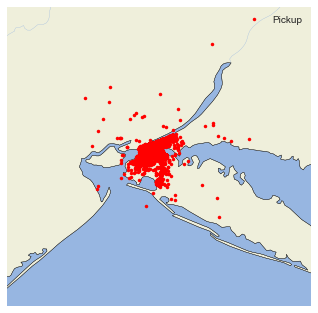

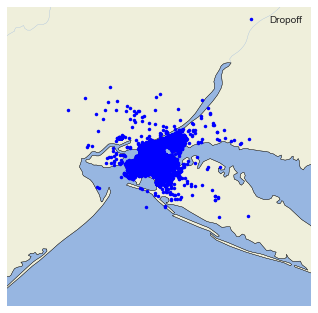

In [19]:
extent = [-74.7, -73.1, 40.3, 41.2]

# Pickup
ax = plt.subplot(1, 2, 1)
ax = plt.axes(projection=ccrs.AlbersEqualArea())
ax.set_extent(extent)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
lon = train.pickup_longitude
lat = train.pickup_latitude


ax.plot(lon, lat, 'r.', transform=ccrs.PlateCarree(), zorder=2, label='Pickup')
ax.coastlines(resolution='10m')
ax.legend()
plt.show()

# Dropoff
ax = plt.subplot(1, 2, 2)
ax = plt.axes(projection=ccrs.AlbersEqualArea())
ax.set_extent(extent)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
lon = train.dropoff_longitude
lat = train.dropoff_latitude

ax.plot(lon, lat, 'b.', transform=ccrs.PlateCarree(), zorder=2, label='Dropoff')
ax.coastlines(resolution='10m')
ax.legend()
plt.show()

In [20]:
# Search nulls and percentage of them
def check_null(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent_1 = df.isnull().sum()/df.isnull().count()*100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    print(missing_data.head(5))

check_null(train)

                    Total    %
trip_duration           0  0.0
store_and_fwd_flag      0  0.0
dropoff_latitude        0  0.0
dropoff_longitude       0  0.0
pickup_latitude         0  0.0


**Preparing the Data**

In [21]:
# Create attributes in weather dataset
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(dtype=np.int32)

weather.Time = pd.to_datetime(weather.Time)
weather = weather[weather.Time.dt.year == 2016]

weather.Conditions = ordinal_encoder.fit_transform(np.array(weather.Conditions).reshape(-1, 1))

weather["pickup_month"] = weather.Time.dt.month
weather["pickup_day"] = weather.Time.dt.day
weather["pickup_hour"] = weather.Time.dt.hour

weather.head()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions,pickup_month,pickup_day,pickup_hour
22,2016-01-01 00:00:00,5.6,3.2,NaN,0.58,1018.8,-2.2,16.1,WNW,11.1,0.0,0.0,None,10,1,1,0
23,2016-01-01 01:00:00,5.6,4.0,NaN,0.53,1018.5,-3.3,16.1,Variable,7.4,0.0,0.0,None,10,1,1,1
24,2016-01-01 02:00:00,5.6,4.0,NaN,0.51,1017.9,-3.9,16.1,Variable,7.4,0.0,0.0,None,10,1,1,2
25,2016-01-01 03:00:00,5.0,3.9,NaN,0.53,1017.8,-3.9,16.1,Variable,5.6,0.0,0.0,None,10,1,1,3
26,2016-01-01 04:00:00,5.0,3.3,NaN,0.55,1017.7,-3.3,16.1,West,7.4,0.0,0.0,None,10,1,1,4


In [22]:
# Remove outliers in train
old_len = len(train)
train = train[(train.trip_duration >= np.percentile(train.trip_duration, 0.99)) &
              (train.trip_duration <= np.percentile(train.trip_duration, 99.99))]
print("Removed {} outliers".format(old_len - len(train)))

Removed 983 outliers


In [24]:
# Calculate distance by using picup and dropoff's latitude and longitude
from geopy import distance

train['distance']  = train.apply(lambda row: distance.geodesic((row['dropoff_latitude'],row['dropoff_longitude']), 
                                        (row['pickup_latitude'], row['pickup_longitude'])).km, axis=1)

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.502172
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.808660
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.379687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.483632
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.187038


In [25]:
# Convert to datetime
train.pickup_datetime = pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime = pd.to_datetime(train.dropoff_datetime)

# Generate some attributes related to time
train['pickup_minute_of_the_day'] = train.pickup_datetime.dt.hour*60 + train.pickup_datetime.dt.minute
train["pickup_month"] = train.pickup_datetime.dt.month
train["pickup_day"] = train.pickup_datetime.dt.day
train["pickup_hour"] = train.pickup_datetime.dt.hour
train['weekday'] = train.pickup_datetime.dt.weekday

train = pd.merge(train, weather[['pickup_month', 'pickup_day', 'pickup_hour','Conditions']], how = 'left', on = ['pickup_month', 'pickup_day', 'pickup_hour'])

# Remove some samples whose datetime doesn't match 
train = train.dropna(subset=["Conditions"])

train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_minute_of_the_day,pickup_month,pickup_day,pickup_hour,weekday,Conditions
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.502172,1044,3,14,17,0,10.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.808660,43,6,12,0,6,15.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.379687,695,1,19,11,1,0.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.483632,1172,4,6,19,2,0.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.187038,810,3,26,13,5,0.0


**Preparing sets**

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, train['trip_duration'], test_size=0.01, random_state=42)

In [27]:
X_train_continuous = X_train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_minute_of_the_day']]
X_train_categorical = X_train[['pickup_month', 'weekday', 'Conditions']]

X_test_continuous = X_test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_minute_of_the_day']]
X_test_categorical = X_test[['pickup_month', 'weekday', 'Conditions']]

X_train_continuous.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,pickup_minute_of_the_day
43668,-73.943657,40.788826,-73.984108,40.742569,6.168604,409
43764,-73.994171,40.751072,-73.959961,40.805069,6.655544,957
41498,-73.976875,40.765053,-73.962105,40.800545,4.133870,917
9710,-73.989006,40.758648,-74.000084,40.758652,0.935431,567
2814,-73.990913,40.724236,-73.860298,40.739025,11.155351,148


In [28]:
# Feature scaling
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_continuous)
X_train_continuous = scaler.transform(X_train_continuous)

X_test_continuous = scaler.transform(X_test_continuous)

**Training the model**

In [29]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Embedding, Dense, Activation, Input, concatenate, Reshape, Dropout


In [30]:
emb_dim = 3  # dimension of the emdedding vectors

# input_dim correponds to the number of possible categories + 1
input0 = Input(shape=(1,))
model0 = Embedding(input_dim=X_train_categorical['pickup_month'].value_counts().size+1,output_dim=emb_dim)(input0)
model0 = Flatten()(model0)

input1 = Input(shape=(1,))
model1 = Embedding(input_dim=X_train_categorical['weekday'].value_counts().size+1, output_dim=emb_dim)(input1)
model1 = Flatten()(model1)

input2 = Input(shape=(1,))
model2 = Embedding(input_dim=X_train_categorical['Conditions'].value_counts().size+3, output_dim=emb_dim)(input2)
model2 = Flatten()(model2)

continuous_input = Input(shape=(X_train_continuous.shape[1], ))

conc_model = concatenate([continuous_input,model0, model1, model2])
dense_model = Dense(units=100, activation='relu')(conc_model)
dense_model = Dropout(0.25)(dense_model)
dense_model = Dense(units=100, activation='relu')(dense_model)
out_model = Dense(units=1)(dense_model)

model = Model(inputs=[continuous_input,input0, input1, input2], outputs=out_model)
sgd = SGD(lr=0.1)
model.compile(optimizer='adam', loss="mean_absolute_error", metrics=["mean_absolute_error"])

history = model.fit([X_train_continuous, np.array(X_train_categorical['pickup_month']), np.array(X_train_categorical['weekday']), np.array(X_train_categorical['Conditions'])], 
          y_train, epochs=50, validation_split = 0.2)

Epoch 1/50
2431/2431 [==============================] - 14s 4ms/step - loss: 509.3900 - mean_absolute_error: 509.3900 - val_loss: 357.7629 - val_mean_absolute_error: 357.7629
Epoch 2/50
2431/2431 [==============================] - 7s 3ms/step - loss: 357.5710 - mean_absolute_error: 357.5710 - val_loss: 346.8776 - val_mean_absolute_error: 346.8776
Epoch 3/50
2431/2431 [==============================] - 7s 3ms/step - loss: 346.3602 - mean_absolute_error: 346.3602 - val_loss: 340.9539 - val_mean_absolute_error: 340.9539
Epoch 4/50
2431/2431 [==============================] - 7s 3ms/step - loss: 360.0694 - mean_absolute_error: 360.0694 - val_loss: 333.8871 - val_mean_absolute_error: 333.8871
Epoch 5/50
2431/2431 [==============================] - 6s 3ms/step - loss: 336.3006 - mean_absolute_error: 336.3006 - val_loss: 328.9668 - val_mean_absolute_error: 328.9668
Epoch 6/50
2431/2431 [==============================] - 7s 3ms/step - loss: 333.4980 - mean_absolute_error: 333.4980 - val_loss: 

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 3)         21          input_1[0][0]                    
______________________________________________________________________________________________

In [43]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


**Checking the trained model**

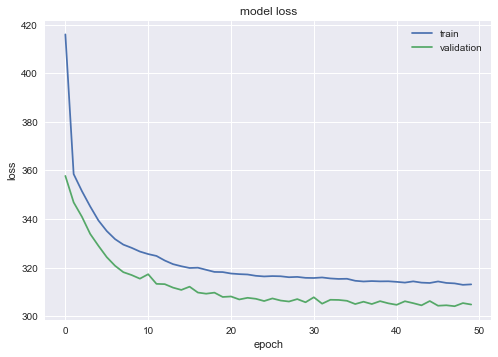

In [35]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [40]:
# Test some samples from test dataset
df_test = pd.DataFrame(data={'trip_duration':y_test[0:10].copy()})

df_test['pred'] = model.predict([X_test_continuous[0:10], np.array(X_test_categorical['pickup_month'])[0:10], 
               np.array(X_test_categorical['weekday'])[0:10], np.array(X_test_categorical['Conditions'])[0:10]]).astype('int32')
df_test['%diff'] = 100 * (df_test['pred'] / df_test['trip_duration'])

df_test.sort_values("%diff", ascending=False)


,trip_duration,pred,%diff
6363,235,460,195.744681
21045,542,743,137.084871
24484,1302,1759,135.099846
44214,408,541,132.598039
24870,1561,1790,114.670083
67551,233,256,109.871245
63934,287,304,105.923345
44700,785,558,71.082803
13538,2417,1497,61.936285
90330,4187,294,7.021734


In [41]:
# Calculate distance between categoricals from embedding
from scipy import spatial

keras_embs0 = model.layers[3].get_weights()[0] 
keras_embs1 = model.layers[4].get_weights()[0] 

spatial.distance.cosine(keras_embs0[2], keras_embs1[3])

1.2259135246276855

**Finding shortest path**

In [42]:
# Install deap library to create the GA model
!pip install deap

In [44]:
np.random.seed(0) 
np.random.rand(0)

# Get locations 
locations_count = 8
indices = list(np.random.randint(0, X_test.shape[0], size=locations_count))
locations_coord = {}

# Get locations' coordinates 
for i in range(len(indices)):
  locations_coord[i] = [X_test.iloc[indices[i]]['pickup_longitude'], X_test.iloc[indices[i]]['pickup_latitude']] 

# Get the categorical attributes
# Those categorical attributes are fixed among the locations used in GA
trip_month = [X_test_categorical.iloc[indices[0]]['pickup_month']]
trip_weekday = [X_test_categorical.iloc[indices[0]]['weekday']]
trip_weather = [X_test_categorical.iloc[indices[0]]['Conditions']]

# Get minute of the day in which the driver starts his trip 
# by using the first location selected in random
start_minute_of_the_day = X_test.iloc[indices[0]]['pickup_minute_of_the_day']

locations_coord

{0: [-73.95455169677734, 40.77022933959961],
 1: [-73.94747161865234, 40.77565002441406],
 2: [-73.9887466430664, 40.76924514770508],
 3: [-73.96492004394531, 40.79147720336913],
 4: [-73.7823486328125, 40.646820068359375],
 5: [-73.99918365478516, 40.72019958496094],
 6: [-73.9896926879883, 40.73686218261719],
 7: [-73.96261596679686, 40.79440307617188]}

In [45]:
# Prepare function to calculate total duration of an indivudual

def evalOneMin(individual):
    total_duration = 0
    current_minute_of_the_day = start_minute_of_the_day
    for i in range(0, len(individual)-1):
        # It should avoid repeating the pathes in individual
        if individual.count(individual[i]) > 1:
            return 99999,
            
        trip_distance = distance.geodesic((locations_coord[individual[i+1]][1], locations_coord[individual[i+1]][0]), 
                                     (locations_coord[individual[i]][1], locations_coord[individual[i]][0])).km

        continuous_sample = scaler.transform([[locations_coord[individual[i]][0], locations_coord[individual[i]][1],
                                   locations_coord[individual[i+1]][0], locations_coord[individual[i+1]][1],
                                   trip_distance, current_minute_of_the_day]])
        
        duration = model.predict([np.array(continuous_sample), np.array(trip_month), np.array(trip_weekday), np.array(trip_weather)])
        
        # current_minute_of_the_day is increased for each pair of location traveled 
        current_minute_of_the_day += int(duration/60)
        total_duration += duration
      
      
    return total_duration,

In [46]:
# GA initializers
import array
import random

from deap import algorithms
from deap import base
from deap import creator
from deap import tools


# Weights is -1 because I want a fitness score as low as possible
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator: generates chromosomes that vary from 0 to (locations_count-1)
toolbox.register("attr_num", random.randint, 0, locations_count-1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_num, locations_count)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalOneMin)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Execute evolution 

random.seed(0)

pop = toolbox.population(n=200)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=30, 
                                stats=stats, halloffame=hof, verbose=True)

pop, log, hof

gen	nevals	avg         	std         	min          	max  
0  	200   	[[99558.92]]	[[6210.156]]	[[11953.713]]	99999
1  	104   	[[98678.46]]	[[10702.117]]	[[11953.713]]	99999
2  	108   	[[97358.24]]	[[15016.727]]	[[11937.268]]	99999
3  	123   	[[96918.1]] 	[[16178.002]]	[[11953.713]]	99999
4  	94    	[[94716.94]]	[[20907.432]]	[[11953.713]]	99999
5  	95    	[[87220.98]]	[[31029.197]]	[[9436.974]] 	99999
6  	117   	[[79273.39]]	[[37395.36]] 	[[9436.974]] 	99999
7  	110   	[[62952.2]] 	[[43536.867]]	[[9436.974]] 	99999
8  	105   	[[41314.875]]	[[41654.902]]	[[9436.974]] 	99999
9  	116   	[[32002.355]]	[[37167.977]]	[[9436.974]] 	99999
10 	106   	[[28282.11]] 	[[34744.055]]	[[9436.974]] 	99999
11 	132   	[[35874.91]] 	[[39999.38]] 	[[9436.974]] 	99999
12 	106   	[[30527.262]]	[[37443.004]]	[[9436.974]] 	99999
13 	104   	[[25137.506]]	[[33882.723]]	[[9001.666]] 	99999
14 	104   	[[27263.426]]	[[35798.98]] 	[[9001.666]] 	99999
15 	106   	[[28064.705]]	[[36528.797]]	[[9001.666]] 	99999
16 	111 

([Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individual('b', [2, 5, 0, 7, 3, 6, 1, 4]),
  Individu

In [50]:
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is {} and its time is {} seg".format(list(best_ind),
             float(best_ind.fitness.values[0])))

Best individual is [2, 5, 0, 7, 3, 6, 1, 4] and its time is 9001.666015625 seg
